#Imports:

In [1]:
%pip install rasterio

In [2]:
%pip install segmentation_models

In [3]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
from tensorflow.keras import layers, Model, Input
import pandas as pd
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

Segmentation Models: using `tf.keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preproccessing:

In [4]:
data_folder = '/content/drive/MyDrive/Cellula internship/Week3/data'
images_folder = os.path.join(data_folder, 'images')
labels_folder = os.path.join(data_folder, 'labels')

In [5]:
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
label_files = [f for f in os.listdir(labels_folder) if os.path.isfile(os.path.join(labels_folder, f))]
images3 = []
labels3 = []
image_files.sort()
label_files.sort()

print("Loading images...")
for image_file in image_files:
    try:
        img_path = os.path.join(images_folder, image_file)
        with rasterio.open(img_path) as src:
            img_data = src.read()  # (C, H, W)
            img_data = np.moveaxis(img_data, 0, -1)  # (H, W, C)
            images3.append(img_data)
        print(f"Loaded image: {image_file}")
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")


print("\nLoading labels...")
for label_file in label_files:
    try:
        label_path = os.path.join(labels_folder, label_file)
        with rasterio.open(label_path) as src:
            label_data = src.read()  # (1, H, W)
            label_data = label_data.squeeze()  # (H, W)
            label_data = (label_data > 0).astype(np.uint8)  # Ensure binary
            labels3.append(label_data)
        print(f"Loaded label: {label_file}")
    except Exception as e:
        print(f"Error loading label {label_file}: {e}")

print(f"\nLoaded {len(images3)} images and {len(labels3)} labels.")


Loading images...
Loaded image: 0.tif
Loaded image: 1.tif
Loaded image: 10.tif


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded image: 100.tif
Loaded image: 101.tif
Loaded image: 102.tif
Loaded image: 103.tif
Loaded image: 104.tif
Loaded image: 105.tif
Loaded image: 106.tif
Loaded image: 107.tif
Loaded image: 108.tif
Loaded image: 109.tif
Loaded image: 11.tif
Loaded image: 110.tif
Loaded image: 111.tif
Loaded image: 112.tif
Loaded image: 113.tif
Loaded image: 114.tif
Loaded image: 115.tif
Loaded image: 116.tif
Loaded image: 117.tif
Loaded image: 118.tif
Loaded image: 119.tif
Loaded image: 12.tif
Loaded image: 120.tif
Loaded image: 121.tif
Loaded image: 122.tif
Loaded image: 123.tif
Loaded image: 124.tif
Loaded image: 125.tif
Loaded image: 126.tif
Loaded image: 127.tif
Loaded image: 128.tif
Loaded image: 129.tif
Loaded image: 13.tif
Loaded image: 130.tif
Loaded image: 131.tif
Loaded image: 132.tif
Loaded image: 133.tif
Loaded image: 134.tif
Loaded image: 135.tif
Loaded image: 136.tif
Loaded image: 137.tif
Loaded image: 138.tif
Loaded image: 139.tif
Loaded image: 14.tif
Loaded image: 140.tif
Loaded image: 

In [6]:
image_files_remaining = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
label_files_remaining = [f for f in os.listdir(labels_folder) if os.path.isfile(os.path.join(labels_folder, f))]

images3_filtered = []
labels3_filtered = []
image_files_remaining.sort()
label_files_remaining.sort()

image_basenames_remaining = {os.path.splitext(f)[0] for f in image_files_remaining}

print("Filtering images and labels...")
# Filter images based on remaining image files
for img_data, img_file in zip(images3, sorted(image_files, key=lambda f: os.path.splitext(f)[0])):
    if os.path.splitext(img_file)[0] in image_basenames_remaining:
        images3_filtered.append(img_data)
    else:
        print(f"Skipping image {img_file} as its corresponding label was removed.")

# Filter labels based on remaining label files
for label_data, label_file in zip(labels3, sorted(label_files, key=lambda f: os.path.splitext(f)[0])):
     if os.path.splitext(label_file)[0] in image_basenames_remaining:
         labels3_filtered.append(label_data)
     else:
         print(f"Skipping label {label_file} as it was moved.")

images3 = images3_filtered
labels3 = labels3_filtered

print(f"\nFiltered {len(images3)} images and {len(labels3)} labels.")

data = pd.DataFrame({"image": images3, "mask": labels3})
display(data.head())

Filtering images and labels...
Skipping label 100_184.png as it was moved.
Skipping label 101_89.png as it was moved.
Skipping label 102_179.png as it was moved.
Skipping label 103_225.png as it was moved.
Skipping label 104_20.png as it was moved.
Skipping label 105_148.png as it was moved.
Skipping label 106_267.png as it was moved.
Skipping label 107_59.png as it was moved.
Skipping label 108_236.png as it was moved.
Skipping label 109_223.png as it was moved.
Skipping label 10_244.png as it was moved.
Skipping label 110_287.png as it was moved.
Skipping label 111_121.png as it was moved.
Skipping label 112_78.png as it was moved.
Skipping label 113_44.png as it was moved.
Skipping label 114_220.png as it was moved.
Skipping label 115_49.png as it was moved.
Skipping label 116_250.png as it was moved.
Skipping label 117_97.png as it was moved.
Skipping label 118_125.png as it was moved.
Skipping label 119_222.png as it was moved.
Skipping label 11_116.png as it was moved.
Skipping l

,image,mask
0,"[[[131, 48, 73, 74, 360, 236, 120, 64, 277, 31...","[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[[233, 182, 405, 218, 3351, 1717, 705, 128, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[[655, 599, 656, 725, 1005, 2088, 2034, 64, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[[577, 717, 1109, 1295, 2963, 3060, 2148, 64,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[[216, 246, 526, 412, 3370, 2061, 975, 64, 69...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
for i in range(len(images3)):
    if images3[i].shape[:2] != labels3[i].shape:
        print(f"Shape mismatch at index {i}: Image {images3[i].shape}, Label {labels3[i].shape}")
    else:
        print(f"Shape match at index {i}: Image {images3[i].shape}, Label {labels3[i].shape}")


Shape match at index 0: Image (128, 128, 12), Label (128, 128)
Shape match at index 1: Image (128, 128, 12), Label (128, 128)
Shape match at index 2: Image (128, 128, 12), Label (128, 128)
Shape match at index 3: Image (128, 128, 12), Label (128, 128)
Shape match at index 4: Image (128, 128, 12), Label (128, 128)
Shape match at index 5: Image (128, 128, 12), Label (128, 128)
Shape match at index 6: Image (128, 128, 12), Label (128, 128)
Shape match at index 7: Image (128, 128, 12), Label (128, 128)
Shape match at index 8: Image (128, 128, 12), Label (128, 128)
Shape match at index 9: Image (128, 128, 12), Label (128, 128)
Shape match at index 10: Image (128, 128, 12), Label (128, 128)
Shape match at index 11: Image (128, 128, 12), Label (128, 128)
Shape match at index 12: Image (128, 128, 12), Label (128, 128)
Shape match at index 13: Image (128, 128, 12), Label (128, 128)
Shape match at index 14: Image (128, 128, 12), Label (128, 128)
Shape match at index 15: Image (128, 128, 12), Lab

In [8]:
print("Image shape:", images3[0].shape)   # Expected: (128, 128, 12)
print("Label shape:", labels3[0].shape)   # Expected: (128, 128)
print("Unique values in label:", np.unique(labels3[0]))  # Should be [0, 1]
print("--------"*20)
print("Image list len:", len(images3))
print("Label list len:", len(labels3))

Image shape: (128, 128, 12)
Label shape: (128, 128)
Unique values in label: [0 1]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Image list len: 306
Label list len: 306


In [9]:
images3[0][0, :, :] # (12, 128, 128)

array([[131,  48,  73, ..., 316,  80,   0],
       [142,  41,  74, ..., 316,  80,   0],
       [142,  50,  88, ..., 317,  30,   0],
       ...,
       [276, 234, 451, ..., 256,  10,   0],
       [276, 241, 479, ..., 250,  10,   0],
       [269, 230, 416, ..., 247,  10,   0]], dtype=int16)

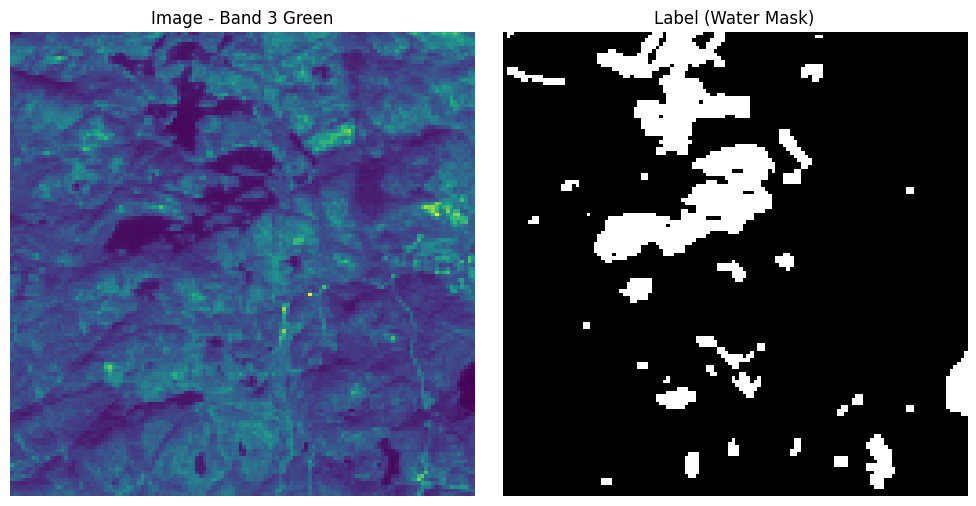

In [11]:
import matplotlib.pyplot as plt

index = 0
image = images3[index][:, :, 3]
mask = labels3[index]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image - Band {3} Green")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Label (Water Mask)")
plt.axis('off')

plt.tight_layout()
plt.show()

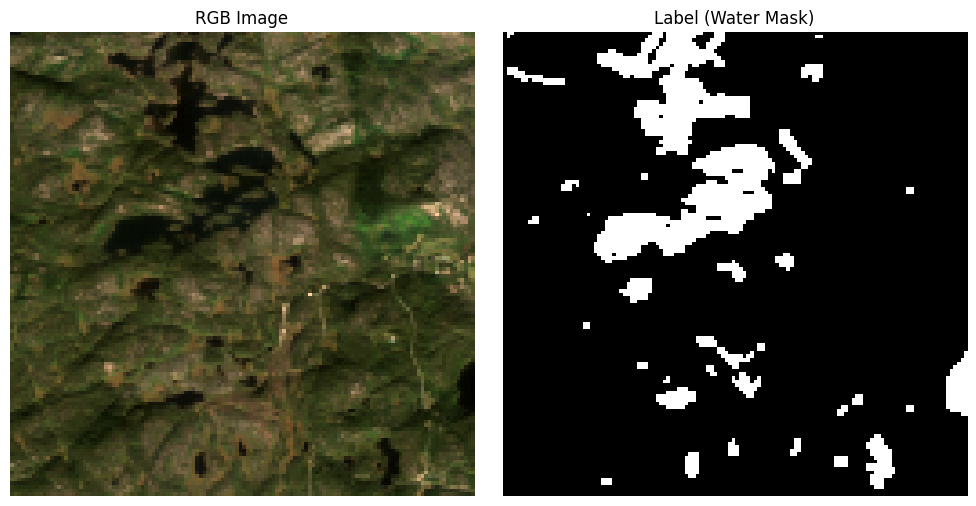

In [12]:
rgb_image = images3[0][:, :, [3,2,1]]

max_val = np.max(rgb_image)
if max_val > 0:
  rgb_image_normalized = rgb_image / max_val
else:
  rgb_image_normalized = rgb_image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image_normalized)
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(labels3[index], cmap='gray')
plt.title("Label (Water Mask)")
plt.axis('off')

plt.tight_layout()
plt.show()

 Key bands for water detection:
NIR (Band 8) → water absorbs NIR → low reflectance

SWIR (Bands 11 & 12) → water also absorbs SWIR → even lower reflectance

Green (Band 3) → water can be slightly reflective



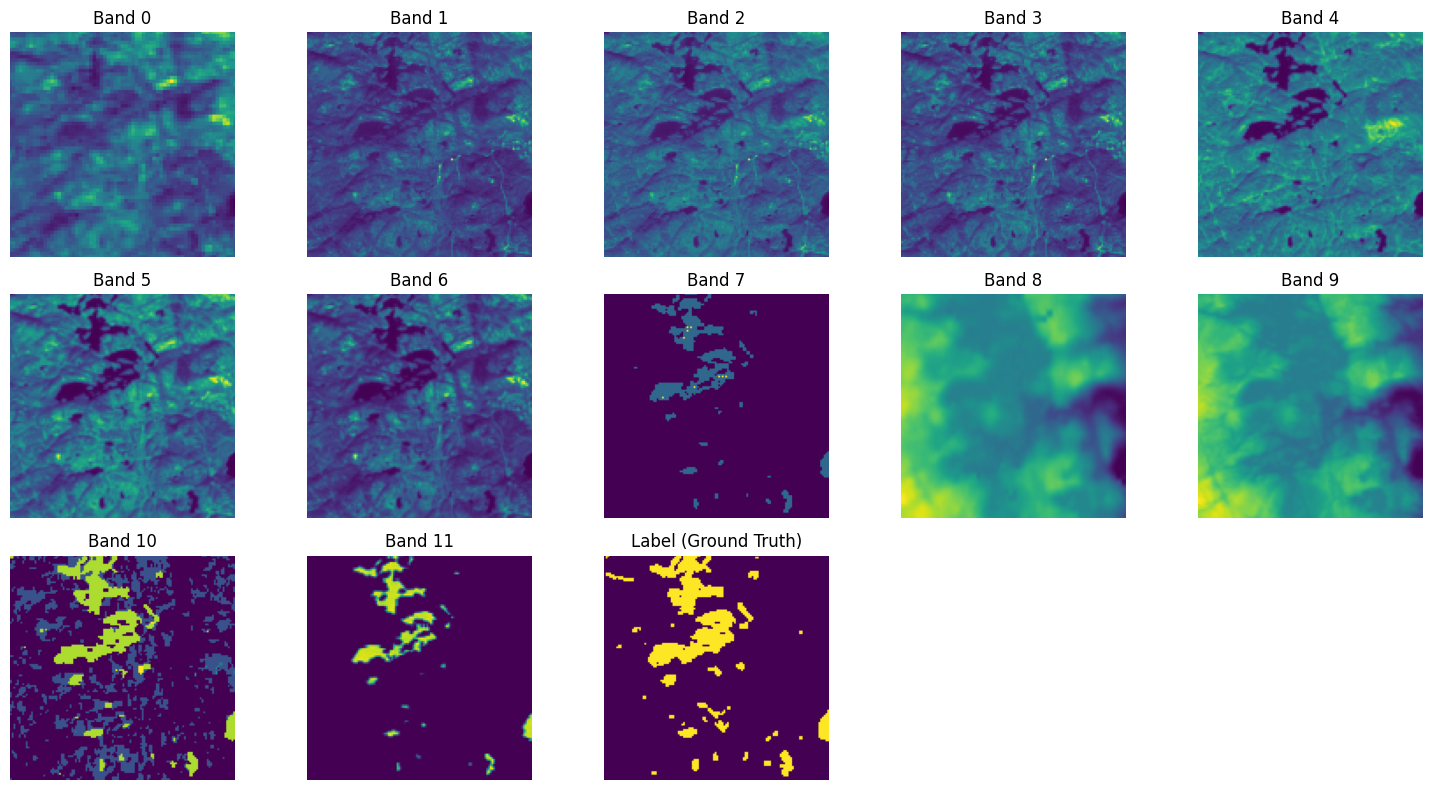

In [13]:
def visualize_bands_and_label(image, label, num_bands=12):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 5, figsize=(15, 8))
    axs = axs.flatten()

    for i in range(num_bands):
        axs[i].imshow(image[:, :, i])
        axs[i].set_title(f"Band {i}")
        axs[i].axis('off')

    axs[num_bands].imshow(label)
    axs[num_bands].set_title("Label (Ground Truth)")
    axs[num_bands].axis('off')

    for j in range(num_bands + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

visualize_bands_and_label(images3[0], labels3[0])

Bands: [2,3,4,5,6,7,10,11]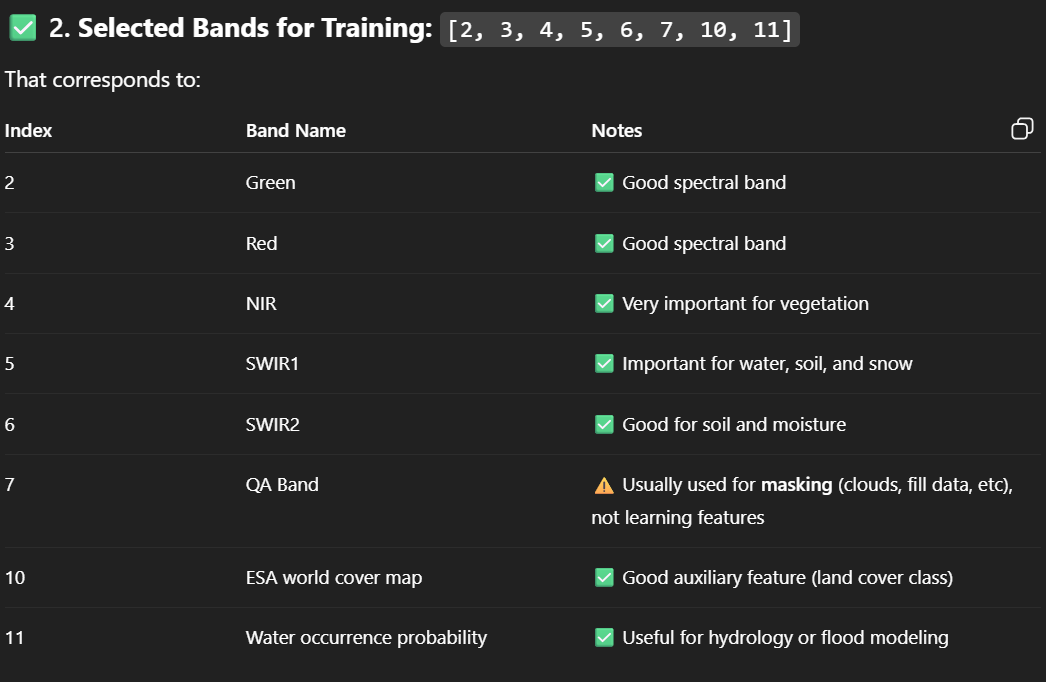

# Normalize data and apply Augmentation

In [10]:
import tensorflow as tf

images3_tf = tf.data.Dataset.from_tensor_slices(images3)
labels3_tf = tf.data.Dataset.from_tensor_slices(labels3)

dataset = tf.data.Dataset.zip((images3_tf, labels3_tf))

print("Created TensorFlow dataset.")

Created TensorFlow dataset.


In [11]:
def augment(image, mask):
    mask = tf.expand_dims(mask, axis=-1) # (H, W, 1)

    # Random flips
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotations
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    # Random zoom (using random crop and resize)
    IMG_HEIGHT = tf.shape(image)[0]
    IMG_WIDTH = tf.shape(image)[1]
    zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.0)
    crop_height = tf.cast(tf.cast(IMG_HEIGHT, tf.float32) * zoom_factor, tf.int32)
    crop_width = tf.cast(tf.cast(IMG_WIDTH, tf.float32) * zoom_factor, tf.int32)

    # Ensure crop size is at least 1x1
    crop_height = tf.maximum(1, crop_height)
    crop_width = tf.maximum(1, crop_width)

    # Ensure crop size does not exceed image size
    crop_height = tf.minimum(crop_height, IMG_HEIGHT)
    crop_width = tf.minimum(crop_width, IMG_WIDTH)

    # Pad if necessary to ensure crop size is not larger than image size
    # This can happen if zoom_factor is close to 1 and image size is small
    padding_h = tf.maximum(0, crop_height - IMG_HEIGHT)
    padding_w = tf.maximum(0, crop_width - IMG_WIDTH)
    image = tf.pad(image, [[0, padding_h], [0, padding_w], [0, 0]], mode='REFLECT')
    mask = tf.pad(mask, [[0, padding_h], [0, padding_w], [0, 0]], mode='REFLECT')

    # Adjust IMG_HEIGHT and IMG_WIDTH to padded dimensions if padding was applied
    IMG_HEIGHT = tf.shape(image)[0]
    IMG_WIDTH = tf.shape(image)[1]
    image = tf.image.random_crop(image, size=[crop_height, crop_width, tf.shape(image)[-1]])
    mask = tf.image.random_crop(mask, size=[crop_height, crop_width, tf.shape(mask)[-1]]) # Mask needs channel dim for random_crop
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Use nearest neighbor for masks

    # Remove channel dimension from mask after augmentations
    mask = tf.squeeze(mask, axis=-1) # (H, W)

    return image, mask


In [12]:
def calculate_min_max(dataset):
    min_vals = None
    max_vals = None

    for image, _ in dataset:
        image = tf.cast(image, tf.float32)
        if min_vals is None:
            min_vals = tf.reduce_min(image, axis=[0, 1])
            max_vals = tf.reduce_max(image, axis=[0, 1])
        else:
            min_vals = tf.minimum(min_vals, tf.reduce_min(image, axis=[0, 1]))
            max_vals = tf.maximum(max_vals, tf.reduce_max(image, axis=[0, 1]))
    return min_vals, max_vals

min_vals, max_vals = calculate_min_max(dataset)
print("Min values per band:", min_vals.numpy())
print("Max values per band:", max_vals.numpy())


def normalize_minmax(image, mask, min_vals, max_vals):
    image = tf.cast(image, tf.float32)
    normalized_image = tf.where(
        tf.equal(max_vals, min_vals),
        tf.zeros_like(image),
        (image - min_vals) / (max_vals - min_vals)
    )
    mask = tf.cast(mask, tf.uint8)
    return normalized_image, mask

normalized_dataset_minmax = dataset.map(lambda x, y: normalize_minmax(x, y, min_vals, max_vals))

print("Min-max normalized dataset created successfully.")

Min values per band: [-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Max values per band: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]
Min-max normalized dataset created successfully.


In [13]:
augmented_dataset = normalized_dataset_minmax.map(augment)

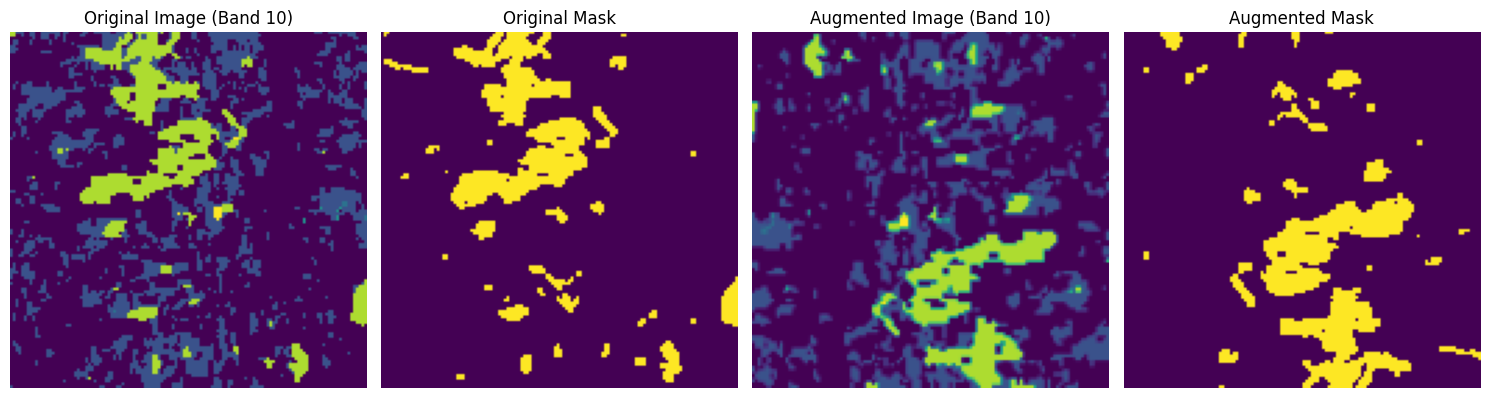

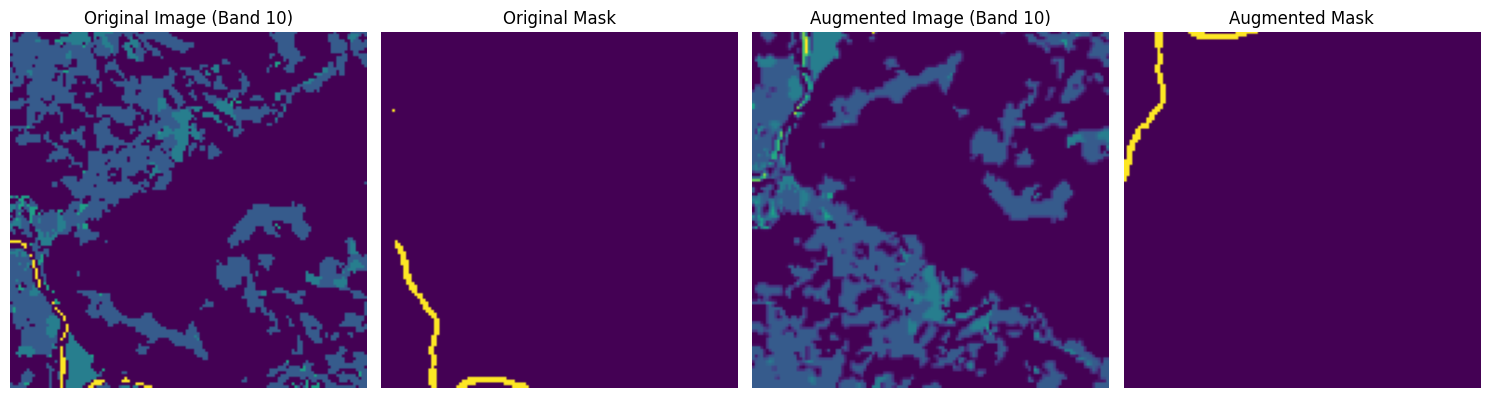

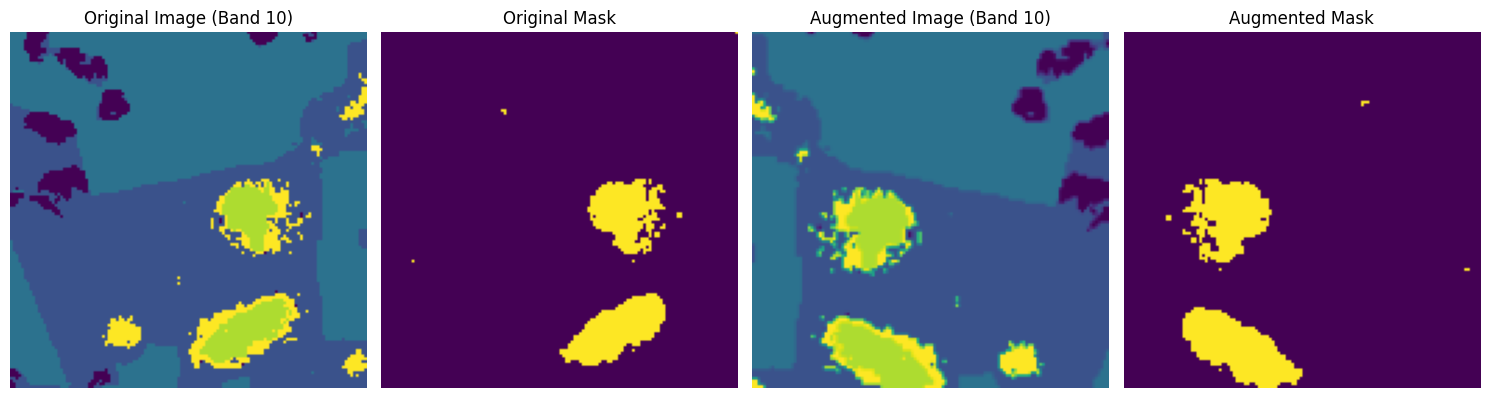

In [14]:
import matplotlib.pyplot as plt

def display_augmentation_examples(original_ds, augmented_ds, num_examples=5):
    original_batch = original_ds.take(num_examples)
    augmented_batch = augmented_ds.take(num_examples)

    for (orig_img, orig_mask), (aug_img, aug_mask) in zip(original_batch, augmented_batch):
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))

        orig_img_np = orig_img.numpy()
        orig_mask_np = orig_mask.numpy()
        aug_img_np = aug_img.numpy()
        aug_mask_np = aug_mask.numpy()

        axs[0].imshow(orig_img_np[:, :, 10])
        axs[0].set_title("Original Image (Band 10)")
        axs[0].axis('off')

        axs[1].imshow(orig_mask_np)
        axs[1].set_title("Original Mask")
        axs[1].axis('off')

        axs[2].imshow(aug_img_np[:, :, 10])
        axs[2].set_title("Augmented Image (Band 10)")
        axs[2].axis('off')

        axs[3].imshow(aug_mask_np)
        axs[3].set_title("Augmented Mask")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

display_augmentation_examples(normalized_dataset_minmax, augmented_dataset, num_examples=3)


In [15]:
def select_bands(image, mask):
    selected_band_indices = [2, 3, 4, 5, 6, 7, 10, 11]
    selected_image = tf.gather(image, indices=selected_band_indices, axis=-1)
    return selected_image, mask

band_selected_dataset = normalized_dataset_minmax.map(select_bands)
augmented_dataset_bands = band_selected_dataset.map(augment)
print("Band selection applied to the dataset.")

for image, mask in band_selected_dataset.take(1):
    new_input_shape = image.shape
    print(f"New input shape for the models: {new_input_shape}")

Band selection applied to the dataset.
New input shape for the models: (128, 128, 8)


# Models:

In [16]:
DATASET_SIZE = len(images3)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
BATCH_SIZE = 16
BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset = augmented_dataset_bands.take(TRAIN_SIZE)
val_dataset = augmented_dataset_bands.skip(TRAIN_SIZE)

train_dataset = train_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=BUFFER_SIZE)

print(f"Training dataset size: {tf.data.experimental.cardinality(train_dataset).numpy() * BATCH_SIZE}")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_dataset).numpy() * BATCH_SIZE}")

Training dataset size: 256
Validation dataset size: 64


## Scratch models:

* unet model:

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
input_shape = (128, 128, 8)
print(f"Input shape for the model: {input_shape}")

model = unet_model(input_size=input_shape)
optmizer =
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

Input shape for the model: (128, 128, 8)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,672 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,034,625 (118.39 MB)

 Trainable params: 31,034,625 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 50
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
print("Model training completed.")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.6978 - loss: 0.5687 - mean_io_u: 0.3690 - val_accuracy: 0.8628 - val_loss: 0.3735 - val_mean_io_u: 0.3827
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.8616 - loss: 0.3782 - mean_io_u: 0.3690 - val_accuracy: 0.8752 - val_loss: 0.3828 - val_mean_io_u: 0.3827
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.8727 - loss: 0.3685 - mean_io_u: 0.3690 - val_accuracy: 0.8830 - val_loss: 0.3535 - val_mean_io_u: 0.3827
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.8803 - loss: 0.3508 - mean_io_u: 0.3690 - val_accuracy: 0.8801 - val_loss: 0.3646 - val_mean_io_u: 0.3827
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - accuracy: 0.8801 - loss: 0.3368 - mean_io_u: 0.3690 - val_accuracy: 0.8856 - val_loss: 0.3271 - val_mean_io_u: 0.3827
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.8822 - loss: 0.3207 - mean_io_u: 0.3690 - val_accuracy: 0.8849 - val_loss: 

In [ ]:
evaluation_results = model.evaluate(val_dataset)

print("\nEvaluation Results on Validation Dataset:")
print(f"  Loss: {evaluation_results[0]:.4f}")
print(f"  Accuracy: {evaluation_results[1]:.4f}")
print(f"  MeanIoU: {evaluation_results[2]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8852 - loss: 0.2701 - mean_io_u: 0.3825

Evaluation Results on Validation Dataset:
  Loss: 0.2759
  Accuracy: 0.8876
  MeanIoU: 0.3827


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


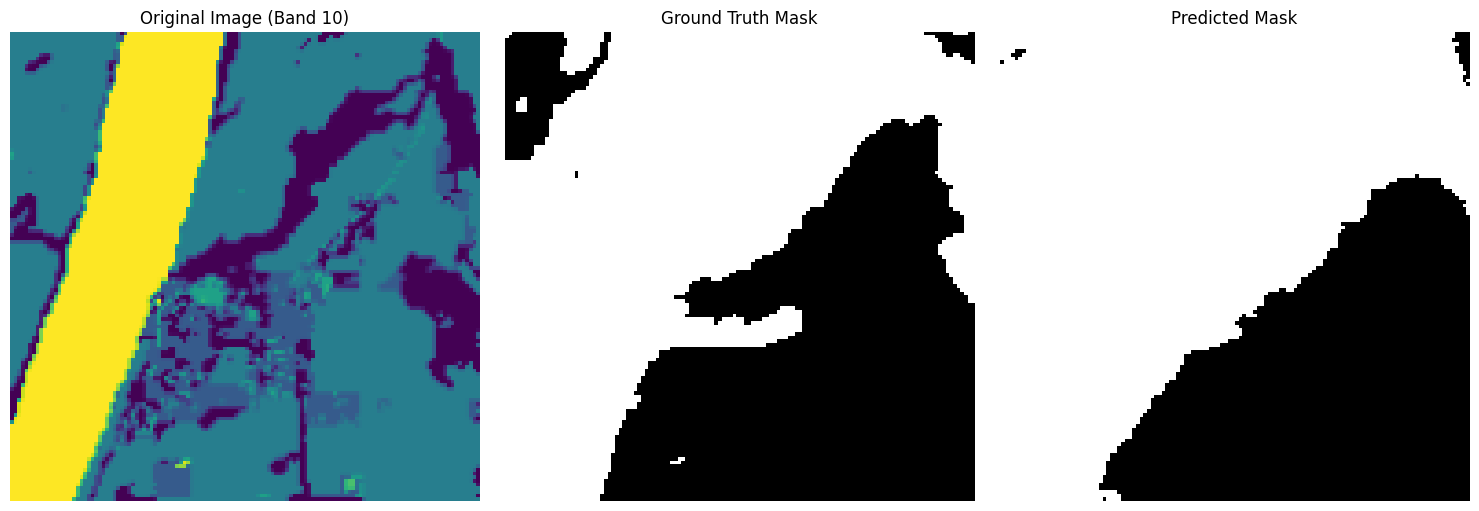

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


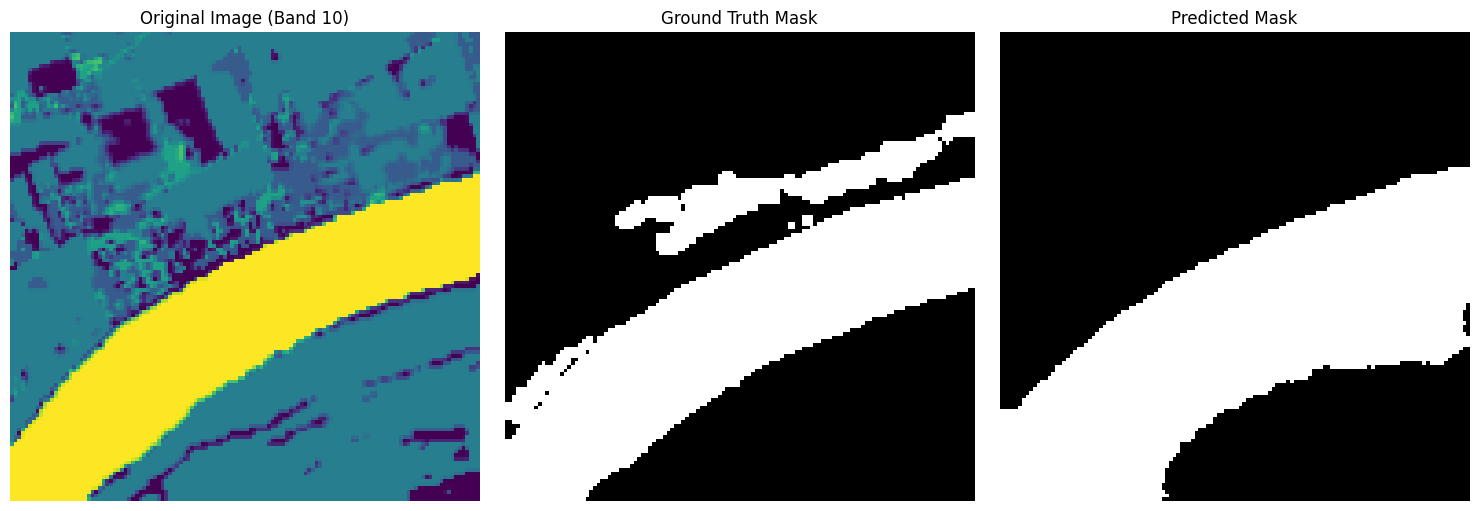

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


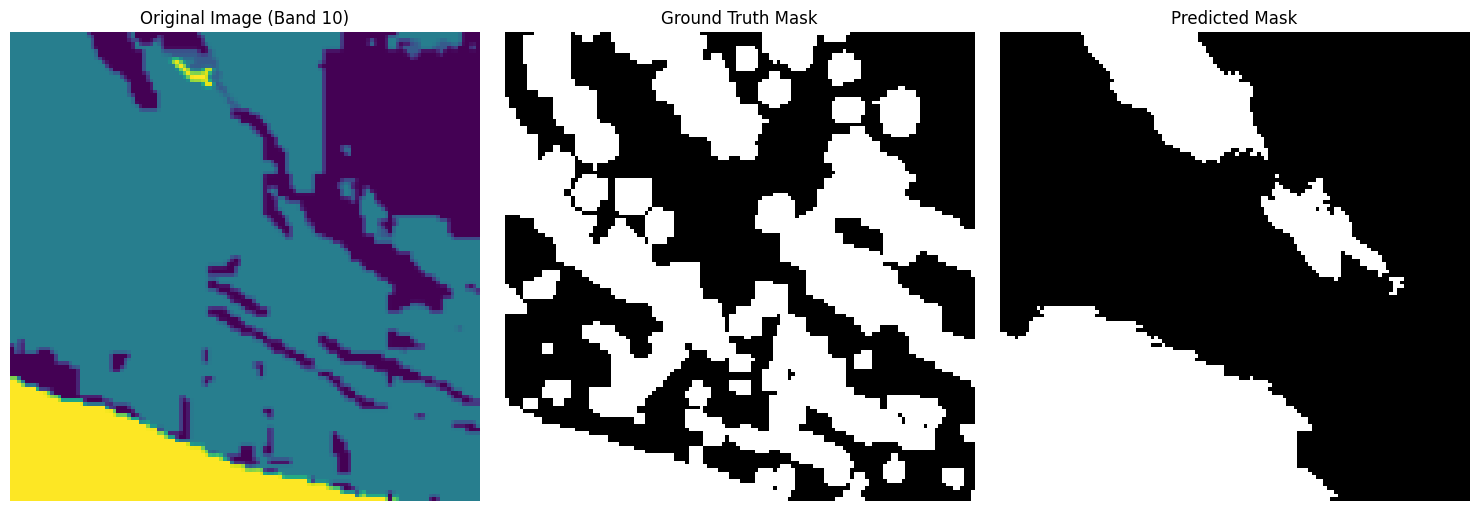

Visualization of prediction examples completed.


In [ ]:
for sample_images, sample_masks in val_dataset.take(1):
    for i in range(min(len(sample_images), 3)):
        image = sample_images[i]
        true_mask = sample_masks[i]

        predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
        predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(15, 5))

        # Display original image (Band 3 for example)
        plt.subplot(1, 3, 1)
        plt.imshow(image[:, :, 6])
        plt.title("Original Image (Band 10)")
        plt.axis('off')

        # Display ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')


        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

print("Visualization of prediction examples completed.")

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import numpy as np

all_true_masks = []
all_predicted_masks = []

print("Evaluating model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = model.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks.append(sample_masks.numpy().flatten())
    all_predicted_masks.append(predicted_masks_binary.flatten())

all_true_masks = np.concatenate(all_true_masks)
all_predicted_masks = np.concatenate(all_predicted_masks)

iou_water = jaccard_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
precision_water = precision_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
recall_water = recall_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')
f1_water = f1_score(all_true_masks, all_predicted_masks, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class):")
print(f"  IoU (Water): {iou_water:.4f}")
print(f"  Precision (Water): {precision_water:.4f}")
print(f"  Recall (Water): {recall_water:.4f}")
print(f"  F1-score (Water): {f1_water:.4f}")

Evaluating model performance on validation dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 8))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step

Class-Specific Evaluation Results (Water Class):
  IoU (Water): 0.5989
  Precision (Water): 0.7859
  Recall (Water): 0.7157
  F1-score (Water): 0.7492


* Deeplab model:

In [ ]:
def build_backbone(input_shape):
    """Builds a modified ResNet backbone for DeepLabV3+."""
    inputs = tf.keras.Input(shape=input_shape, name="backbone_input")

    # Initial convolution and pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name="backbone_conv1")(inputs)
    x = layers.BatchNormalization(name="backbone_bn1")(x)
    x = layers.ReLU(name="backbone_relu1")(x)
    low_level_features = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name="backbone_pool1")(x) # This will be our low-level feature output

    # Residual blocks (simplified for demonstration)
    # Block 1
    identity = low_level_features
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv2_1")(low_level_features)
    x = layers.BatchNormalization(name="backbone_bn2_1")(x)
    x = layers.ReLU(name="backbone_relu2_1")(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv2_2")(x)
    x = layers.BatchNormalization(name="backbone_bn2_2")(x)
    x = layers.add([x, identity], name="backbone_add1")
    x = layers.ReLU(name="backbone_relu2_2")(x)

    # Block 2 (with downsampling)
    identity = layers.Conv2D(128, (1, 1), strides=(2, 2), use_bias=False, name="backbone_conv3_0")(x) # Projection shortcut
    identity = layers.BatchNormalization(name="backbone_bn3_0")(identity)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, name="backbone_conv3_1")(x)
    x = layers.BatchNormalization(name="backbone_bn3_1")(x)
    x = layers.ReLU(name="backbone_relu3_1")(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, name="backbone_conv3_2")(x)
    x = layers.BatchNormalization(name="backbone_bn3_2")(x)
    x = layers.add([x, identity], name="backbone_add2")
    x = layers.ReLU(name="backbone_relu3_2")(x)

    # Return the model object
    return tf.keras.Model(inputs=inputs, outputs=[low_level_features, x], name="backbone")

def atrous_spatial_pyramid_pooling(inputs):
    input_shape = inputs.shape
    target_height = input_shape[1]
    target_width = input_shape[2]

    # 1x1 convolution branch
    conv1x1 = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_conv1x1")(inputs)
    conv1x1 = layers.BatchNormalization(name="aspp_bn1")(conv1x1)
    conv1x1 = layers.ReLU(name="aspp_relu1")(conv1x1)

    # 3x3 atrous convolution branches with different rates
    atrous_rates = [6, 12, 18]
    atrous_outputs = []
    for i, rate in enumerate(atrous_rates):
        atrous_conv = layers.Conv2D(256, (3, 3), strides=(1, 1), dilation_rate=rate, padding='same', use_bias=False, name=f"aspp_atrous_conv{i+1}")(inputs)
        atrous_conv = layers.BatchNormalization(name=f"aspp_bn{i+2}")(atrous_conv)
        atrous_conv = layers.ReLU(name=f"aspp_relu{i+2}")(atrous_conv)
        atrous_outputs.append(atrous_conv)

    # Global average pooling branch
    global_avg_pool = layers.GlobalAveragePooling2D(name="aspp_global_avg_pool")(inputs)
    global_avg_pool = layers.Reshape((1, 1, input_shape[-1]), name="aspp_reshape")(global_avg_pool)
    global_avg_pool = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_pool_conv1x1")(global_avg_pool)
    global_avg_pool = layers.BatchNormalization(name="aspp_bn5")(global_avg_pool) # Assuming 3 atrous convs + 1x1 conv + pool conv
    global_avg_pool = layers.ReLU(name="aspp_relu5")(global_avg_pool)
    global_avg_pool = layers.Resizing(target_height, target_width, interpolation='bilinear', name="aspp_pool_resize")(global_avg_pool)


    # Concatenate all branches
    concatenated = layers.concatenate([conv1x1] + atrous_outputs + [global_avg_pool], name="aspp_concatenate")

    # Final 1x1 convolution after concatenation
    output = layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name="aspp_final_conv1x1")(concatenated)
    output = layers.BatchNormalization(name="aspp_final_bn")(output)
    output = layers.ReLU(name="aspp_final_relu")(output)

    # Return the output tensor
    return output


def build_deeplabv3plus(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Build Backbone model
    backbone = build_backbone(input_shape)
    low_level_features, high_level_features = backbone(inputs)

    # Build ASPP Module and get output tensor
    aspp_output = atrous_spatial_pyramid_pooling(high_level_features)

    # Build Decoder
    # 1. Apply 1x1 convolution and batch normalization to low-level features
    low_level_features_processed = layers.Conv2D(48, (1, 1), padding='same', use_bias=False, name="decoder_low_conv1x1")(low_level_features)
    low_level_features_processed = layers.BatchNormalization(name="decoder_low_bn1")(low_level_features_processed)
    low_level_features_processed = layers.ReLU(name="decoder_low_relu1")(low_level_features_processed)

    # 3. Upsample the output of the ASPP module
    # Get the static spatial dimensions from the shape attribute
    low_level_shape = low_level_features_processed.shape
    target_height = low_level_shape[1]
    target_width = low_level_shape[2]

    # Use Resizing layer which is compatible with Functional API
    upsampled_aspp = layers.Resizing(target_height, target_width, interpolation='bilinear', name="decoder_aspp_resize")(aspp_output)


    # 4. Concatenate the processed low-level features and the upsampled ASPP output
    concatenated = layers.concatenate([upsampled_aspp, low_level_features_processed], name="decoder_concatenate")

    # 5. Apply one or more 3x3 convolutions, batch normalization, and ReLU
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', use_bias=False, name="decoder_conv1")(concatenated)
    x = layers.BatchNormalization(name="decoder_bn1")(x)
    x = layers.ReLU(name="decoder_relu1")(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', use_bias=False, name="decoder_conv2")(x)
    x = layers.BatchNormalization(name="decoder_bn2")(x)
    x = layers.ReLU(name="decoder_relu2")(x)

    # 6. Apply a final 1x1 convolution with a single filter and a sigmoid activation
    output = layers.Conv2D(1, (1, 1), activation='sigmoid', name="decoder_output_conv")(x)

    # The final output needs to be upsampled to the original input image size
    # Get original input shape from the input_shape argument
    original_height = input_shape[0]
    original_width = input_shape[1]

    output = layers.Resizing(original_height, original_width, interpolation='bilinear', name="final_output_resize")(output)


    model = tf.keras.Model(inputs=inputs, outputs=output, name="DeepLabV3Plus")
    return model

# Instantiate the full DeepLabV3+ model
input_shape = (128, 128, 8) # Use the actual shape of the loaded images
deeplabv3plus_model = build_deeplabv3plus(input_shape)

# Print the model summary
deeplabv3plus_model.summary()

Model: "DeepLabV3Plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ backbone            │ [(None, 32, 32,   │    330,496 │ input_image[0][0] │
│ (Functional)        │ 64), (None, 16,   │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_global_avg_po… │ (None, 128)       │          0 │ backbone[0][1]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_reshape        │ (None, 1, 1, 128) │          0 │ aspp_global_avg_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_pool_conv1x1   │ (None, 1, 1, 256) │     32,768 │ aspp_reshape[0][… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_conv1x1        │ (None, 16, 16,    │     32,768 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv1   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv2   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_atrous_conv3   │ (None, 16, 16,    │    294,912 │ backbone[0][1]    │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn5            │ (None, 1, 1, 256) │      1,024 │ aspp_pool_conv1x… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn1            │ (None, 16, 16,    │      1,024 │ aspp_conv1x1[0][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn2            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn3            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_bn4            │ (None, 16, 16,    │      1,024 │ aspp_atrous_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu5 (ReLU)   │ (None, 1, 1, 256) │          0 │ aspp_bn5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu1 (ReLU)   │ (None, 16, 16,    │          0 │ aspp_bn1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_relu2 (ReLU)   │ (None, 16, 16,    │          0 │ aspp_bn2[0][0]  

 Total params: 2,910,401 (11.10 MB)

 Trainable params: 2,905,057 (11.08 MB)

 Non-trainable params: 5,344 (20.88 KB)

In [ ]:
deeplabv3plus_model.compile(optimizer='adam',
                            loss='binary_crossentropy',
                            metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

EPOCHS = 50
print(f"Starting training for {EPOCHS} epochs...")
history = deeplabv3plus_model.fit(train_dataset,
                                  epochs=EPOCHS,
                                  validation_data=val_dataset)
print("Model training completed.")

evaluation_results = deeplabv3plus_model.evaluate(val_dataset)

print("\nEvaluation Results on Validation Dataset:")
print(f"  Loss: {evaluation_results[0]:.4f}")
print(f"  Accuracy: {evaluation_results[1]:.4f}")
print(f"  MeanIoU: {evaluation_results[2]:.4f}")

Starting training for 50 epochs...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7053 - loss: 0.6604 - mean_io_u_1: 0.3977 - val_accuracy: 0.8506 - val_loss: 0.5676 - val_mean_io_u_1: 0.4146
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8757 - loss: 0.3678 - mean_io_u_1: 0.3948 - val_accuracy: 0.8321 - val_loss: 0.4392 - val_mean_io_u_1: 0.3827
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8786 - loss: 0.3156 - mean_io_u_1: 0.3690 - val_accuracy: 0.8364 - val_loss: 0.3844 - val_mean_io_u_1: 0.3827
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8879 - loss: 0.2713 - mean_io_u_1: 0.3690 - val_accuracy: 0.8452 - val_loss: 0.3651 - val_mean_io_u_1: 0.3827
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8906 - loss: 0.2535 - mean_io_u_1: 0.3690 - val_accuracy: 0.8350 - val_loss: 0.3735 - val_mean_io_u_1: 0.3827
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.8931 - loss: 0.2403 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


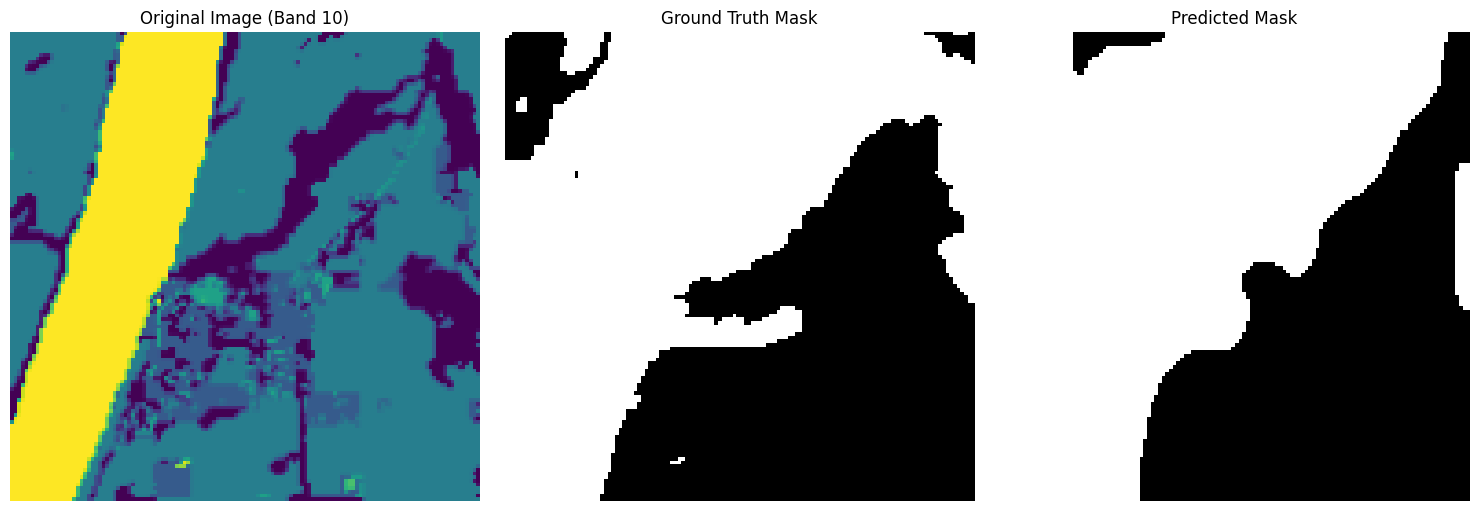

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


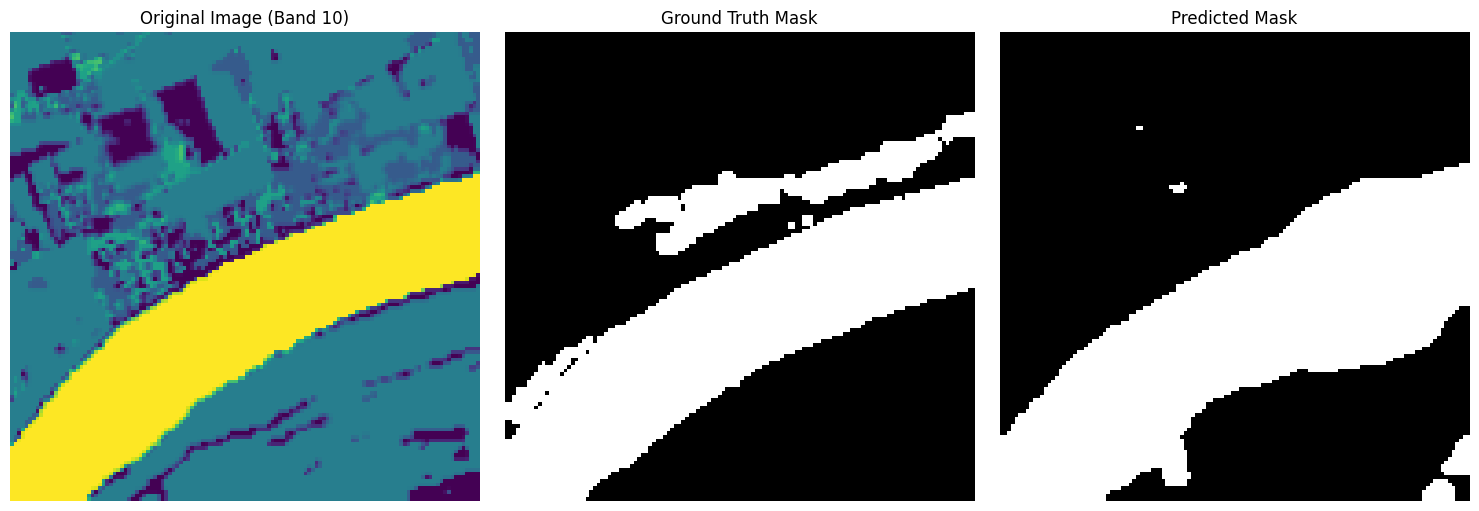

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


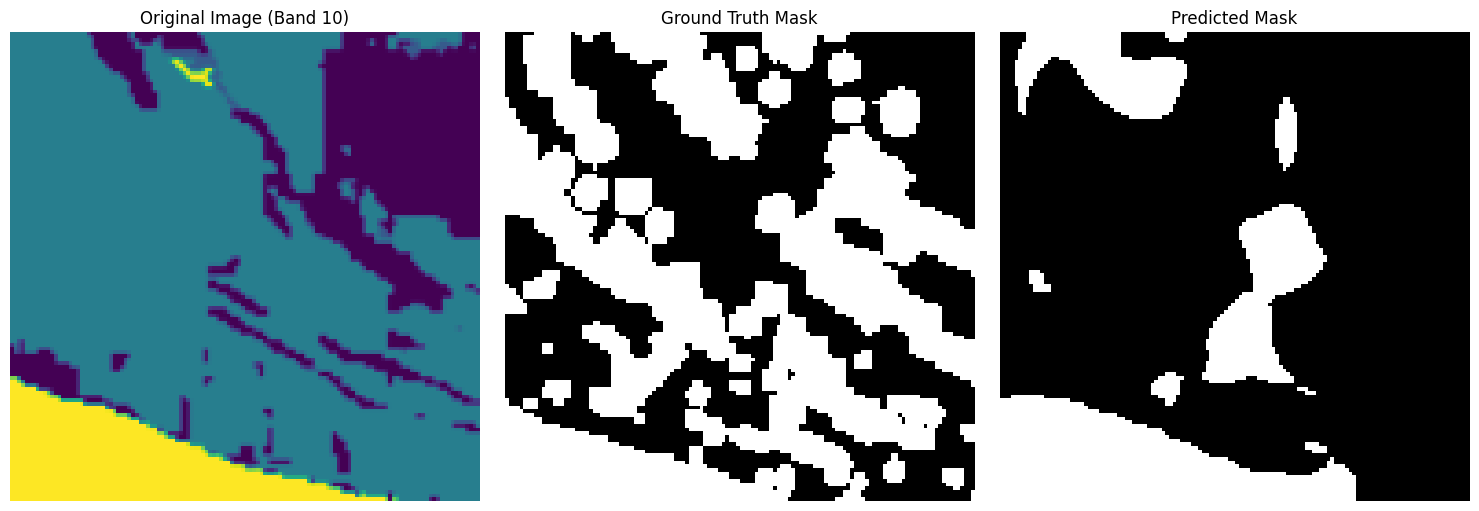

Visualization of DeepLabV3+ prediction examples completed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def display_predictions(model, dataset, num_examples=3):
       for sample_images, sample_masks in dataset.take(1):
        for i in range(min(len(sample_images), num_examples)):
            image = sample_images[i]
            true_mask = sample_masks[i]
            predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[:, :, 6])
            plt.title("Original Image (Band 10)")
            plt.axis('off')


            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')


            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

display_predictions(deeplabv3plus_model, val_dataset, num_examples=3)

print("Visualization of DeepLabV3+ prediction examples completed.")

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import numpy as np

all_true_masks_deepM = []
all_predicted_masks_deepM = []

print("Evaluating model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = model.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks_deepM.append(sample_masks.numpy().flatten())
    all_predicted_masks_deepM.append(predicted_masks_binary.flatten())

all_true_masks_deepM = np.concatenate(all_true_masks_deepM)
all_predicted_masks_deepM = np.concatenate(all_predicted_masks_deepM)

iou_water_deepM = jaccard_score(all_true_masks_deepM, all_predicted_masks_deepM, pos_label=1, average='binary')
precision_water_deepM = precision_score(all_true_masks_deepM, all_predicted_masks_deepM, pos_label=1, average='binary')
recall_water_deepM = recall_score(all_true_masks_deepM, all_predicted_masks_deepM, pos_label=1, average='binary')
f1_water_deepM = f1_score(all_true_masks_deepM, all_predicted_masks_deepM, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class):")
print(f"  IoU (Water): {iou_water_deepM:.4f}")
print(f"  Precision (Water): {precision_water_deepM:.4f}")
print(f"  Recall (Water): {recall_water_deepM:.4f}")
print(f"  F1-score (Water): {f1_water_deepM:.4f}")

Evaluating model performance on validation dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step

Class-Specific Evaluation Results (Water Class):
  IoU (Water): 0.5989
  Precision (Water): 0.7859
  Recall (Water): 0.7157
  F1-score (Water): 0.7492


##Transfer_learining:

* Unet Model:

In [21]:
unet_model_pretrained = sm.Unet(
    backbone_name='resnet34',
    input_shape=new_input_shape,
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

In [22]:
unet_model_pretrained.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=sm.losses.DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)
unet_model_pretrained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         24 │ data[0][0]        │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     25,088 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,471,849 (93.35 MB)

 Trainable params: 24,454,489 (93.29 MB)

 Non-trainable params: 17,360 (67.81 KB)

In [25]:
EPOCHS = 50
print(f"Starting training for {EPOCHS} epochs...")
history_unet = unet_model_pretrained.fit(train_dataset,
                                  epochs=EPOCHS,
                                  validation_data=val_dataset)
print("Unet model training completed.")

Starting training for 50 epochs...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.6237 - loss: 0.6166 - mean_io_u: 0.3686 - val_accuracy: 0.6878 - val_loss: 0.8065 - val_mean_io_u: 0.3824
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7899 - loss: 0.4823 - mean_io_u: 0.3686 - val_accuracy: 0.6949 - val_loss: 0.6941 - val_mean_io_u: 0.3824
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8356 - loss: 0.4167 - mean_io_u: 0.3686 - val_accuracy: 0.8260 - val_loss: 0.6512 - val_mean_io_u: 0.3824
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8687 - loss: 0.3639 - mean_io_u: 0.3686 - val_accuracy: 0.8397 - val_loss: 0.6161 - val_mean_io_u: 0.3824
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8837 - loss: 0.3272 - mean_io_u: 0.3686 - val_accuracy: 0.8361 - val_loss: 0.6179 - val_mean_io_u: 0.3824
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8985 - loss: 0.3029 - mean_io_u: 0.3686 

In [26]:
print("Evaluating Unet model on validation dataset...")
evaluation_results_unet = unet_model_pretrained.evaluate(val_dataset)

print("\nEvaluation Results (Unet Model) on Validation Dataset:")
print(f"  Loss: {evaluation_results_unet[0]:.4f}")
print(f"  Accuracy: {evaluation_results_unet[1]:.4f}")
print(f"  MeanIoU: {evaluation_results_unet[2]:.4f}")

Evaluating Unet model on validation dataset...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8793 - loss: 0.3008 - mean_io_u: 0.3788

Evaluation Results (Unet Model) on Validation Dataset:
  Loss: 0.3165
  Accuracy: 0.8801
  MeanIoU: 0.3824


Displaying predictions for functional_1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


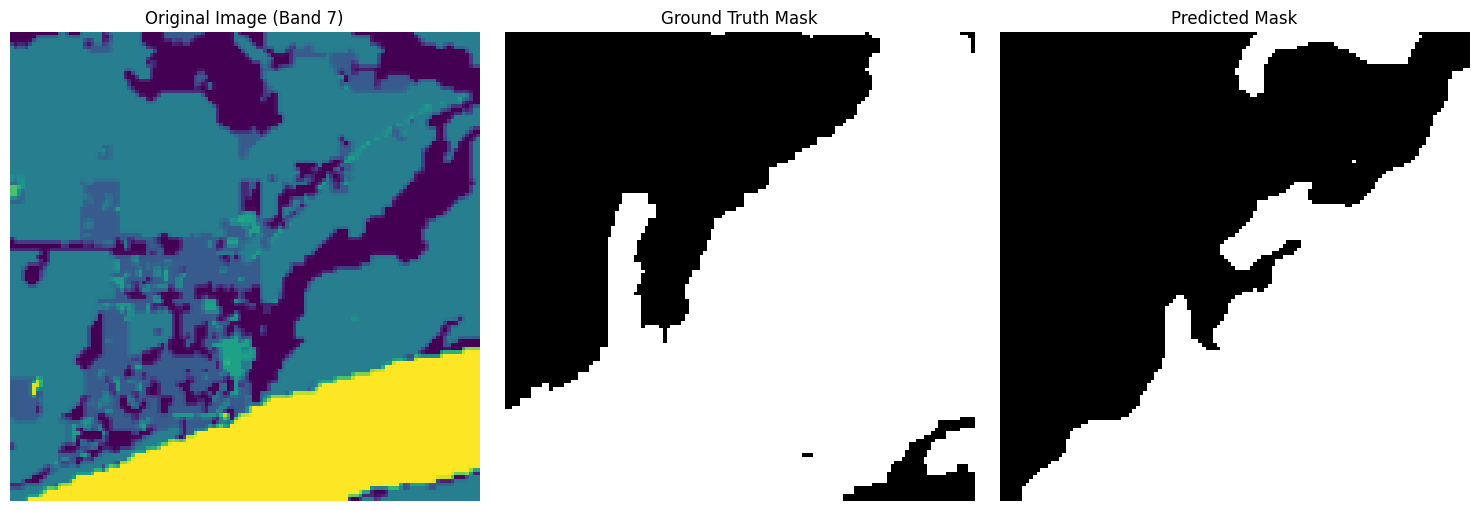

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


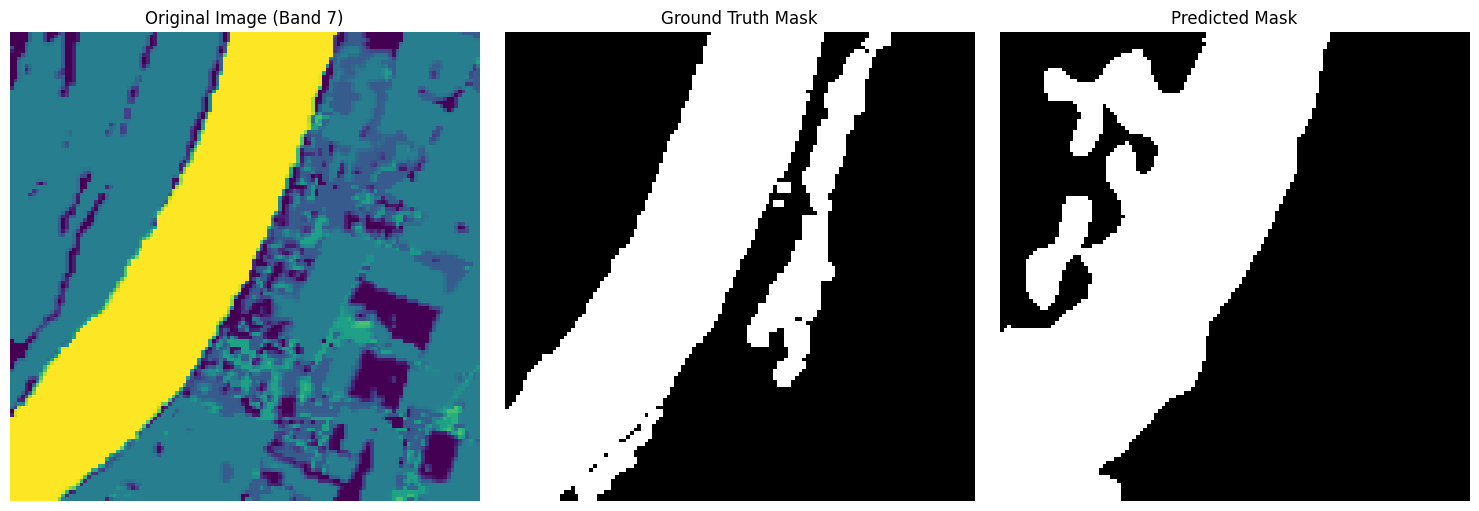

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


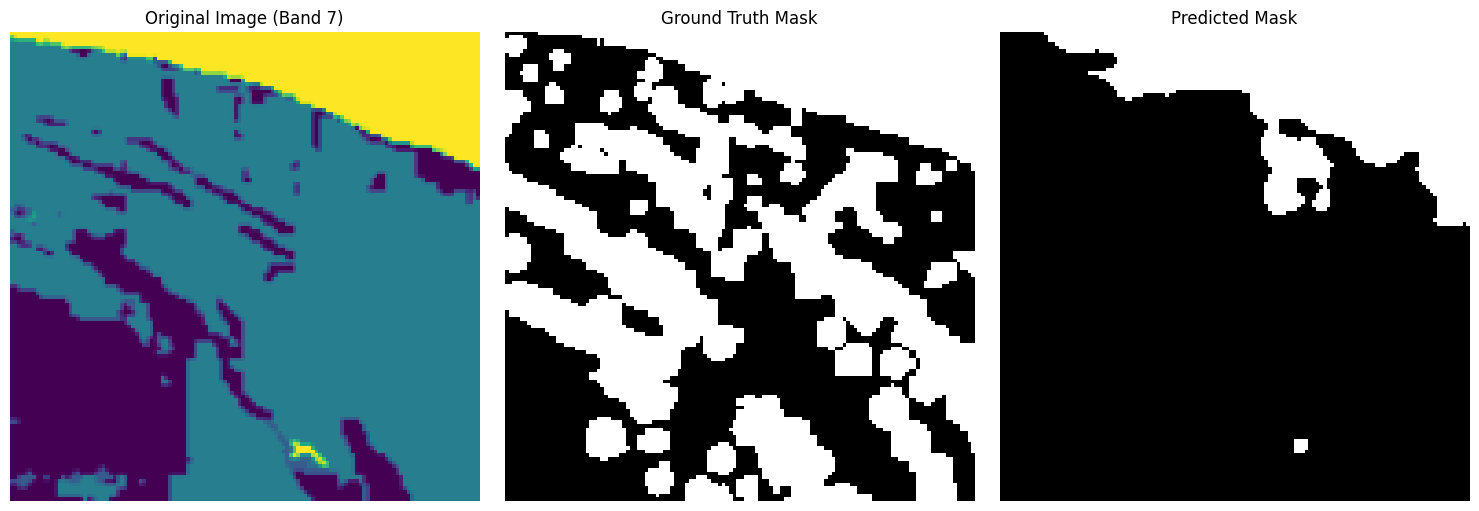

In [27]:
def display_predictions(model, dataset, num_examples=3, band_to_display=6):
    print(f"Displaying predictions for {model.name}...")
    for sample_images, sample_masks in dataset.take(1):
        for i in range(min(len(sample_images), num_examples)):
            image = sample_images[i]
            true_mask = sample_masks[i]
            predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[:, :, band_to_display])
            plt.title(f"Original Image (Band {band_to_display + 1})")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

display_predictions(unet_model_pretrained, val_dataset, num_examples=3)


In [28]:
all_true_masks_unet = []
all_predicted_masks_unet = []

print("Evaluating Unet model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = unet_model_pretrained.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks_unet.append(sample_masks.numpy().flatten())
    all_predicted_masks_unet.append(predicted_masks_binary.flatten())

all_true_masks_unet = np.concatenate(all_true_masks_unet)
all_predicted_masks_unet = np.concatenate(all_predicted_masks_unet)

iou_water_unet = jaccard_score(all_true_masks_unet, all_predicted_masks_unet, pos_label=1, average='binary')
precision_water_unet = precision_score(all_true_masks_unet, all_predicted_masks_unet, pos_label=1, average='binary')
recall_water_unet = recall_score(all_true_masks_unet, all_predicted_masks_unet, pos_label=1, average='binary')
f1_water_unet = f1_score(all_true_masks_unet, all_predicted_masks_unet, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class) for Unet Model:")
print(f"  IoU (Water): {iou_water_unet:.4f}")
print(f"  Precision (Water): {precision_water_unet:.4f}")
print(f"  Recall (Water): {recall_water_unet:.4f}")
print(f"  F1-score (Water): {f1_water_unet:.4f}")

Evaluating Unet model performance on validation dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Class-Specific Evaluation Results (Water Class) for Unet Model:
  IoU (Water): 0.5577
  Precision (Water): 0.8084
  Recall (Water): 0.6427
  F1-score (Water): 0.7160


* Fpn Model:

In [29]:
fpn_model = sm.FPN(
    backbone_name='efficientnetb0',
    input_shape=new_input_shape,
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

/usr/local/lib/python3.11/dist-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 8 input channels.
  warnings.warn(


In [30]:
fpn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=sm.losses.DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)
fpn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      2,304 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b

 Total params: 7,039,933 (26.86 MB)

 Trainable params: 6,995,613 (26.69 MB)

 Non-trainable params: 44,320 (173.12 KB)

In [31]:
EPOCHS = 50
print(f"Starting training for {EPOCHS} epochs...")
history_fpn = fpn_model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=val_dataset)
print("FPN model training completed.")

Starting training for 50 epochs...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.6946 - loss: 0.5576 - mean_io_u_1: 0.3690 - val_accuracy: 0.7648 - val_loss: 0.7546 - val_mean_io_u_1: 0.3824
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7663 - loss: 0.3982 - mean_io_u_1: 0.3767 - val_accuracy: 0.7648 - val_loss: 0.8191 - val_mean_io_u_1: 0.3824
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8175 - loss: 0.3408 - mean_io_u_1: 0.3918 - val_accuracy: 0.7648 - val_loss: 0.8921 - val_mean_io_u_1: 0.3824
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8480 - loss: 0.2995 - mean_io_u_1: 0.4049 - val_accuracy: 0.7648 - val_loss: 0.9419 - val_mean_io_u_1: 0.3824
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.8558 - loss: 0.2884 - mean_io_u_1: 0.4230 - val_accuracy: 0.7648 - val_loss: 0.9586 - val_mean_io_u_1: 0.3824
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8662 - loss: 0.2675 

In [32]:
print("\nEvaluating FPN model on validation dataset...")
evaluation_results_fpn = fpn_model.evaluate(val_dataset)

print("\nEvaluation Results (FPN Model) on Validation Dataset:")
print(f"  Loss: {evaluation_results_fpn[0]:.4f}")
print(f"  Accuracy: {evaluation_results_fpn[1]:.4f}")
print(f"  MeanIoU: {evaluation_results_fpn[2]:.4f}")


Evaluating FPN model on validation dataset...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8638 - loss: 0.3414 - mean_io_u_1: 0.4541

Evaluation Results (FPN Model) on Validation Dataset:
  Loss: 0.3676
  Accuracy: 0.8600
  MeanIoU: 0.4633


Displaying predictions for functional_2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


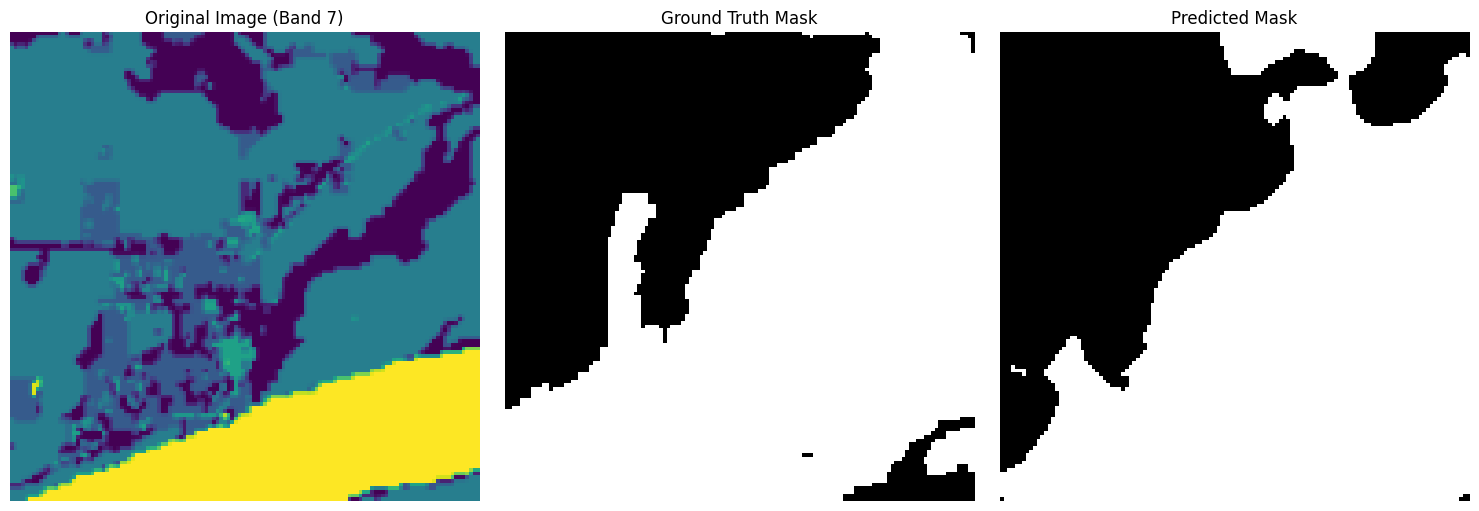

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


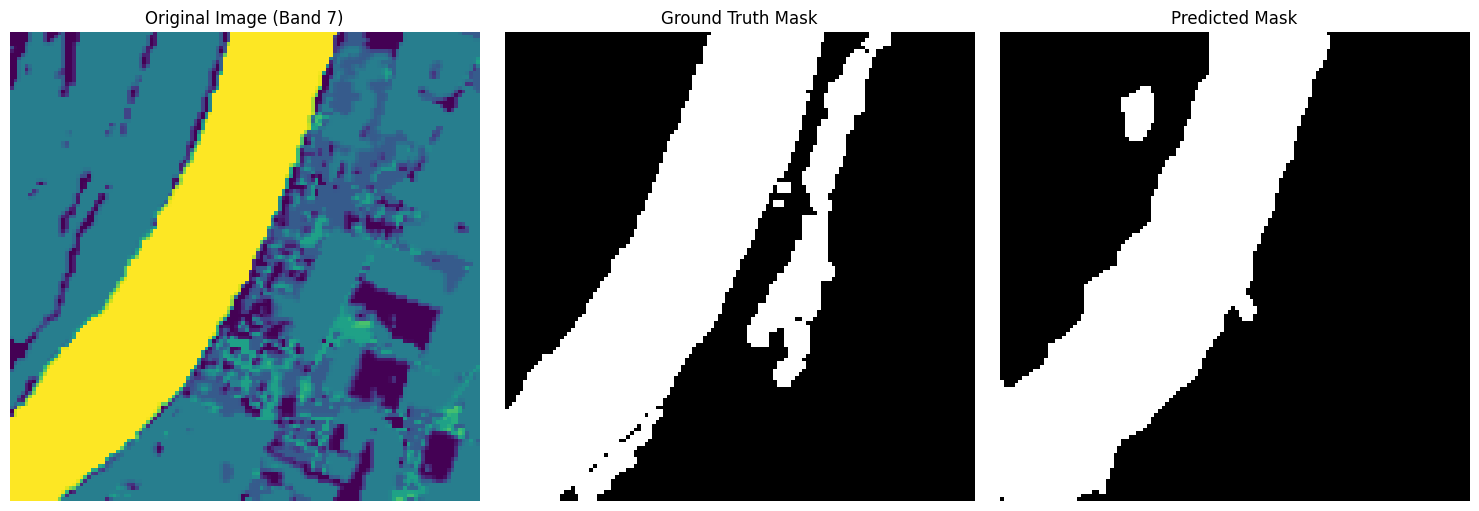

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


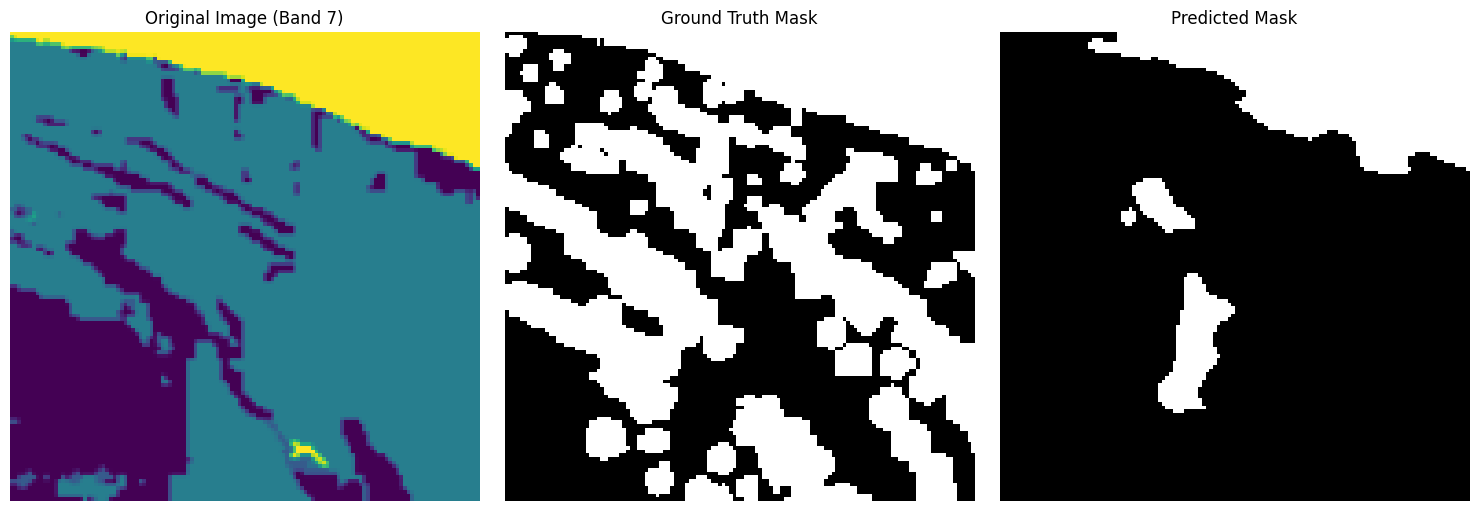

In [33]:
display_predictions(fpn_model, val_dataset, num_examples=3)

In [34]:
all_true_masks_fpn = []
all_predicted_masks_fpn = []

print("Evaluating FPN model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = fpn_model.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks_fpn.append(sample_masks.numpy().flatten())
    all_predicted_masks_fpn.append(predicted_masks_binary.flatten())

all_true_masks_fpn = np.concatenate(all_true_masks_fpn)
all_predicted_masks_fpn = np.concatenate(all_predicted_masks_fpn)

iou_water_fpn = jaccard_score(all_true_masks_fpn, all_predicted_masks_fpn, pos_label=1, average='binary')
precision_water_fpn = precision_score(all_true_masks_fpn, all_predicted_masks_fpn, pos_label=1, average='binary')
recall_water_fpn = recall_score(all_true_masks_fpn, all_predicted_masks_fpn, pos_label=1, average='binary')
f1_water_fpn = f1_score(all_true_masks_fpn, all_predicted_masks_fpn, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class) for FPN Model:")
print(f"  IoU (Water): {iou_water_fpn:.4f}")
print(f"  Precision (Water): {precision_water_fpn:.4f}")
print(f"  Recall (Water): {recall_water_fpn:.4f}")
print(f"  F1-score (Water): {f1_water_fpn:.4f}")

Evaluating FPN model performance on validation dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Class-Specific Evaluation Results (Water Class) for FPN Model:
  IoU (Water): 0.4817
  Precision (Water): 0.7885
  Recall (Water): 0.5532
  F1-score (Water): 0.6502


## Fine Tuning:

In [17]:
unet_model_pretrained_FineT = sm.Unet(
    backbone_name='resnet34',
    input_shape=new_input_shape,
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

In [18]:
for layer in unet_model_pretrained_FineT.layers:
    layer.trainable = False

In [21]:
all_layer_names = [layer.name for layer in unet_model_pretrained_FineT.layers]
split_point_found = False
decoder_layers_to_unfreeze = []

for layer_name in reversed(all_layer_names):
    if any(keyword in layer_name for keyword in ['decoder', 'up', 'transpose']):
         decoder_layers_to_unfreeze.append(layer_name)
         split_point_found = True
    elif split_point_found:
         if any(keyword in layer_name for keyword in ['add', 'concatenate']):
              decoder_layers_to_unfreeze.append(layer_name)
         else:
             if 'stage' in layer_name or 'conv' in layer_name and not any(keyword in layer_name for keyword in ['decoder', 'up', 'transpose', 'add', 'concatenate']):
                 break

In [23]:
len(decoder_layers_to_unfreeze)

40

In [24]:
print("Unfreezing decoder layers:")
for layer in unet_model_pretrained_FineT.layers:
    if layer.name in decoder_layers_to_unfreeze:
        layer.trainable = True
        print(f"- {layer.name}")

Unfreezing decoder layers:
- add_15
- decoder_stage0_upsampling
- decoder_stage0_concat
- decoder_stage0a_conv
- decoder_stage0a_bn
- decoder_stage0a_relu
- decoder_stage0b_conv
- decoder_stage0b_bn
- decoder_stage0b_relu
- decoder_stage1_upsampling
- decoder_stage1_concat
- decoder_stage1a_conv
- decoder_stage1a_bn
- decoder_stage1a_relu
- decoder_stage1b_conv
- decoder_stage1b_bn
- decoder_stage1b_relu
- decoder_stage2_upsampling
- decoder_stage2_concat
- decoder_stage2a_conv
- decoder_stage2a_bn
- decoder_stage2a_relu
- decoder_stage2b_conv
- decoder_stage2b_bn
- decoder_stage2b_relu
- decoder_stage3_upsampling
- decoder_stage3_concat
- decoder_stage3a_conv
- decoder_stage3a_bn
- decoder_stage3a_relu
- decoder_stage3b_conv
- decoder_stage3b_bn
- decoder_stage3b_relu
- decoder_stage4_upsampling
- decoder_stage4a_conv
- decoder_stage4a_bn
- decoder_stage4a_relu
- decoder_stage4b_conv
- decoder_stage4b_bn
- decoder_stage4b_relu


In [25]:
unet_model_pretrained_FineT.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=sm.losses.DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

print("\nUnet model recompiled with decoder layers unfrozen.")
unet_model_pretrained_FineT.summary()


Unet model recompiled with decoder layers unfrozen.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         24 │ data[0][0]        │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     25,088 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,471,849 (93.35 MB)

 Trainable params: 3,151,552 (12.02 MB)

 Non-trainable params: 21,320,297 (81.33 MB)

In [26]:
EPOCHS = 50
print(f"Starting fine-tuning for {EPOCHS} epochs...")
history_unet_fine_tune = unet_model_pretrained_FineT.fit(train_dataset,
                                                 epochs=EPOCHS,
                                                 validation_data=val_dataset)
print("Fine-tuning of Unet model completed.")

Starting fine-tuning for 50 epochs...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6694 - loss: 0.6079 - mean_io_u: 0.3674 - val_accuracy: 0.2600 - val_loss: 0.6209 - val_mean_io_u: 0.3814
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7980 - loss: 0.4961 - mean_io_u: 0.3674 - val_accuracy: 0.2799 - val_loss: 0.6037 - val_mean_io_u: 0.3814
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8139 - loss: 0.4494 - mean_io_u: 0.3674 - val_accuracy: 0.3758 - val_loss: 0.5935 - val_mean_io_u: 0.3814
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8273 - loss: 0.4214 - mean_io_u: 0.3674 - val_accuracy: 0.5849 - val_loss: 0.5735 - val_mean_io_u: 0.3814
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8396 - loss: 0.4010 - mean_io_u: 0.3674 - val_accuracy: 0.7280 - val_loss: 0.5495 - val_mean_io_u: 0.3814
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8526 - loss: 0.3838 - mean_io_u: 0.3674 - v

In [27]:
print("\nEvaluating Fine-tuned Unet model on validation dataset...")
evaluation_results_unet_fine_tune = unet_model_pretrained_FineT.evaluate(val_dataset)

print("\nEvaluation Results (Fine-tuned Unet Model) on Validation Dataset:")
print(f"  Loss: {evaluation_results_unet_fine_tune[0]:.4f}")
print(f"  Accuracy: {evaluation_results_unet_fine_tune[1]:.4f}")
print(f"  MeanIoU: {evaluation_results_unet_fine_tune[2]:.4f}")


Evaluating Fine-tuned Unet model on validation dataset...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8704 - loss: 0.3912 - mean_io_u: 0.3803

Evaluation Results (Fine-tuned Unet Model) on Validation Dataset:
  Loss: 0.4062
  Accuracy: 0.8694
  MeanIoU: 0.3814


Displaying predictions for functional_1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


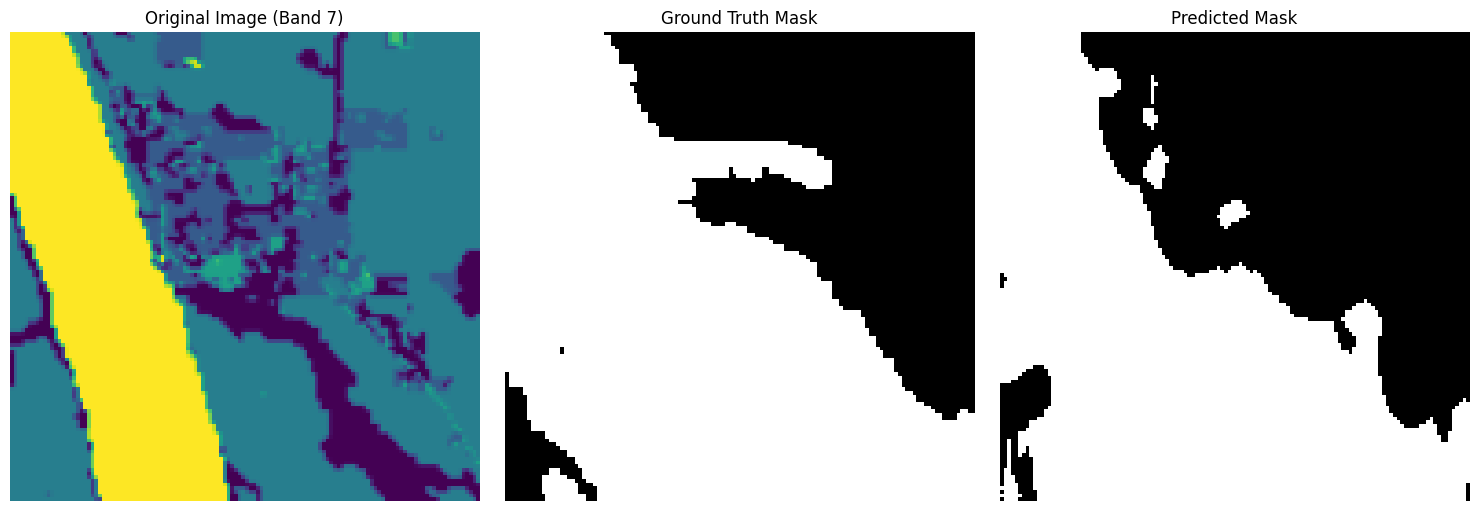

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


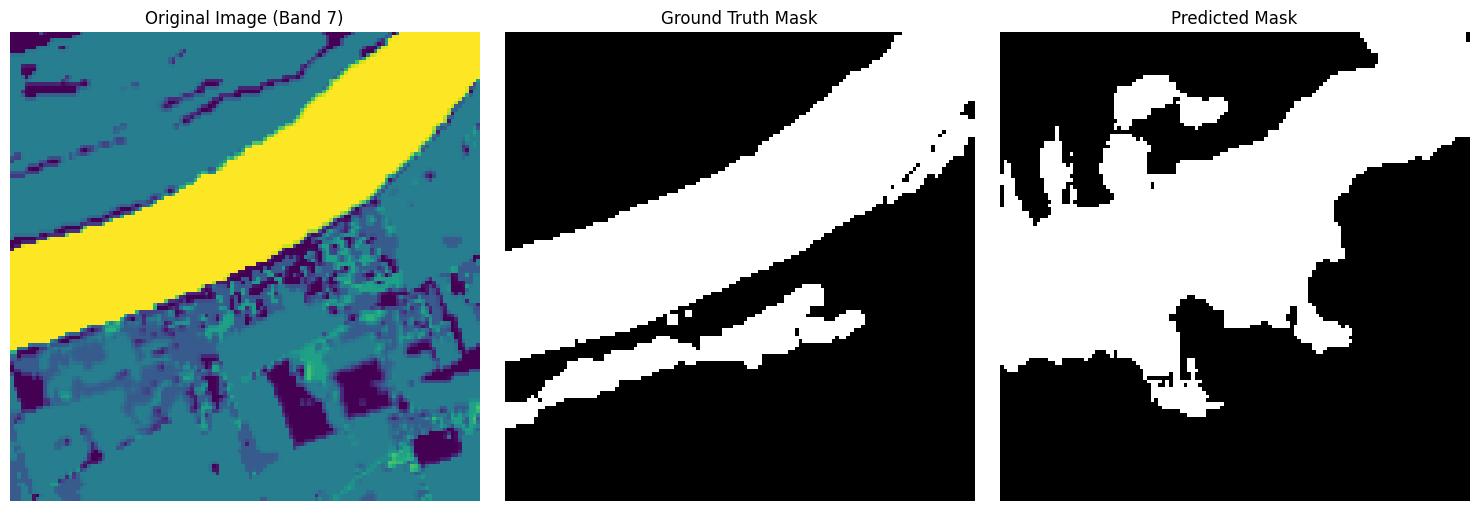

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


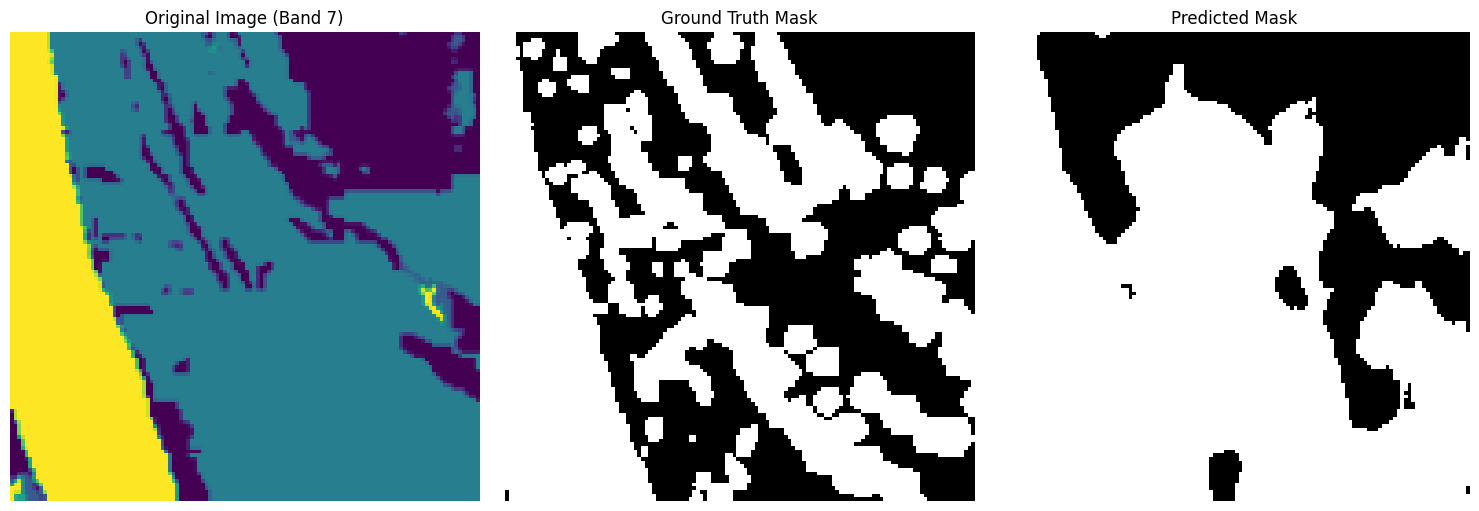

In [28]:
def display_predictions(model, dataset, num_examples=3, band_to_display=6):
    print(f"Displaying predictions for {model.name}...")
    for sample_images, sample_masks in dataset.take(1):
        for i in range(min(len(sample_images), num_examples)):
            image = sample_images[i]
            true_mask = sample_masks[i]
            predicted_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[:, :, band_to_display])
            plt.title(f"Original Image (Band {band_to_display + 1})")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask_binary.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

display_predictions(unet_model_pretrained_FineT, val_dataset, num_examples=3)


In [29]:
all_true_masks_unetFT = []
all_predicted_masks_unetFT = []

print("Evaluating Unet Fine tunned model performance on validation dataset...")

for sample_images, sample_masks in val_dataset:
    predicted_masks = unet_model_pretrained_FineT.predict(sample_images)
    predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)
    all_true_masks_unetFT.append(sample_masks.numpy().flatten())
    all_predicted_masks_unetFT.append(predicted_masks_binary.flatten())

all_true_masks_unetFT = np.concatenate(all_true_masks_unetFT)
all_predicted_masks_unetFT = np.concatenate(all_predicted_masks_unetFT)

iou_water_unet = jaccard_score(all_true_masks_unetFT, all_predicted_masks_unetFT, pos_label=1, average='binary')
precision_water_unet = precision_score(all_true_masks_unetFT, all_predicted_masks_unetFT, pos_label=1, average='binary')
recall_water_unet = recall_score(all_true_masks_unetFT, all_predicted_masks_unetFT, pos_label=1, average='binary')
f1_water_unet = f1_score(all_true_masks_unetFT, all_predicted_masks_unetFT, pos_label=1, average='binary')


print("\nClass-Specific Evaluation Results (Water Class) for Unet Model:")
print(f"  IoU (Water): {iou_water_unet:.4f}")
print(f"  Precision (Water): {precision_water_unet:.4f}")
print(f"  Recall (Water): {recall_water_unet:.4f}")
print(f"  F1-score (Water): {f1_water_unet:.4f}")

Evaluating Unet Fine tunned model performance on validation dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Class-Specific Evaluation Results (Water Class) for Unet Model:
  IoU (Water): 0.5516
  Precision (Water): 0.7482
  Recall (Water): 0.6773
  F1-score (Water): 0.7110
